In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as torchfunc
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

### Loading Data

In [2]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

100%|██████████| 26421880/26421880 [00:00<00:00, 31308070.69it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 2941474.19it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4508303.90it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4166784.44it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw


In [3]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [9]:
print(len(training_data),len(validation_data),len(test_data))
print(training_data[0][0].shape)

50000 10000 10000
torch.Size([1, 28, 28])


### CNN Baseline Model
Model with two CNN layers (including max pooling), one dense and an output classification layer, with suitable number of filters and units, respectively.

In [23]:
def cnn_model():
    """
    Model with two CNN layers, one dense and an output classification layer, with suitable number of filters and units, respectively.
    :return:
    """
    ### YOUR CODE HERE
    class CNNModel(torch.nn.Module):
        def __init__(self, num_classes=10):
            super(CNNModel, self).__init__()
            self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
            self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
            self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            self.fc1 = torch.nn.Linear(64 * 7 * 7, num_classes)
    
        def forward(self, x):
            x = self.pool(torchfunc.relu(self.conv1(x)))
            x = self.pool(torchfunc.relu(self.conv2(x)))
            x = x.view(-1, 64 * 7 * 7)
            x = self.fc1(x)
            return x


    ### YOUR CODE HERE
    return CNNModel()

In [24]:
model = cnn_model()
from torchsummary import summary
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Linear-5                   [-1, 10]          31,370
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 0.19
Estimated Total Size (MB): 0.55
----------------------------------------------------------------


### Training

Implement the training / evaluation loop
Remember training / validation cost and accuracy per epoch and return them as list.

In [25]:
def train_eval(model, optimizer, nepochs, training_loader, test_loader, scheduler=None):
    """
    Perform training and evaluation loop.
    :param model: Model to be trained
    :param optimizer: Optimiser to use for training
    :param nepochs: Number of epochs
    :param training_loader: Loader to provide mini-batches of training samples
    :param test_loader: Loader to provide mini-batches of validation samples
    :param scheduler: Scheduler used for a learning rate schedule
    :return: Lists with training and validation cost and accuracy per epoch.
    """
    cost_hist = []
    cost_hist_test = []
    acc_hist = []
    acc_hist_test = []

    cost_ce = torch.nn.CrossEntropyLoss()
        
    for epoch in range(nepochs):

        ### YOUR CODE HERE ###
        model.train()
        train_total = 0
        cost, acc = 0.0, 0.0
        for batch, (X, Y) in enumerate(training_loader):
            pred = model(X)
            loss = cost_ce(pred, Y)
            cost += loss.item()
            acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()
            train_total += Y.size(0)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if scheduler:
            scheduler.step()

        cost = cost / train_total
        acc = acc / train_total

        test_loss, test_correct, test_total = 0, 0, 0
        with torch.no_grad():
            for X, Y in test_loader:
                pred = model(X)
                loss = cost_ce(pred, Y)

                test_loss += loss.item()
                test_correct += (pred.argmax(1) == Y).type(torch.float).sum().item()
                test_total += Y.size(0)

        cost_test = test_loss / test_total
        acc_test = test_correct / test_total

        print(f"Epoch {epoch}: Train Loss: {cost:.4f}, Train Acc: {acc:.4f}, Test Loss: {cost_test:.4f}, Test Acc: {acc_test:.4f}")

        cost_hist.append(cost)
        cost_hist_test.append(cost_test)
        acc_hist.append(acc)
        acc_hist_test.append(acc_test)
    return cost_hist, cost_hist_test, acc_hist, acc_hist_test

### Train Baseline CNN Model

Follow the "Steps to Test and Tune a Model" as presented in the lecture.

Train the baseline with SGD without momentum and fixed learning rate. Tune the learning rate by this procedure.

Determine a suitable number of epochs.

In [26]:
def plot_performance(cost_hist, cost_hist_test, acc_hist, acc_hist_test):
    f = plt.figure(figsize=(12,4))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.plot(cost_hist, label='Training cost')
    ax1.plot(cost_hist_test, label='Testing cost')
    ax1.legend()
    ax1.grid()
    ax2.plot(acc_hist, label='Training accuracy')
    ax2.plot(acc_hist_test, label='Test accuracy')
    ax2.legend()
    ax2.grid()

Epoch 0: Train Loss: 0.0040, Train Acc: 0.9067, Test Loss: 0.0050, Test Acc: 0.8897
Epoch 1: Train Loss: 0.0038, Train Acc: 0.9124, Test Loss: 0.0042, Test Acc: 0.9079
Epoch 2: Train Loss: 0.0036, Train Acc: 0.9165, Test Loss: 0.0044, Test Acc: 0.9011
Epoch 3: Train Loss: 0.0035, Train Acc: 0.9203, Test Loss: 0.0041, Test Acc: 0.9083
Epoch 4: Train Loss: 0.0033, Train Acc: 0.9234, Test Loss: 0.0060, Test Acc: 0.8663
Epoch 5: Train Loss: 0.0032, Train Acc: 0.9256, Test Loss: 0.0040, Test Acc: 0.9132
Epoch 6: Train Loss: 0.0031, Train Acc: 0.9283, Test Loss: 0.0043, Test Acc: 0.9041
Epoch 7: Train Loss: 0.0030, Train Acc: 0.9323, Test Loss: 0.0040, Test Acc: 0.9122
Epoch 8: Train Loss: 0.0029, Train Acc: 0.9333, Test Loss: 0.0040, Test Acc: 0.9129
Epoch 9: Train Loss: 0.0028, Train Acc: 0.9359, Test Loss: 0.0045, Test Acc: 0.8955


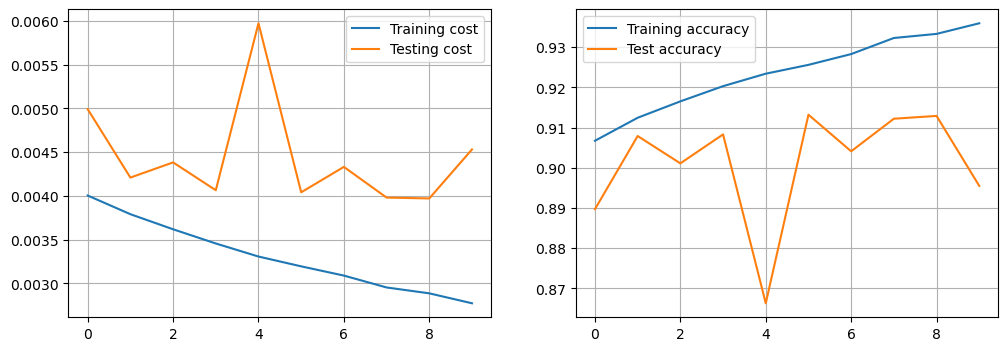

In [28]:
from torch import optim

batch_size = 64

training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

learning_rate = 0.1
nepochs = 10

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0)

cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs, training_loader, test_loader)

plot_performance(cost_hist, cost_hist_test, acc_hist, acc_hist_test)

Epoch 0: Train Loss: 0.0023, Train Acc: 0.9481, Test Loss: 0.0036, Test Acc: 0.9227
Epoch 1: Train Loss: 0.0022, Train Acc: 0.9498, Test Loss: 0.0036, Test Acc: 0.9223
Epoch 2: Train Loss: 0.0022, Train Acc: 0.9513, Test Loss: 0.0036, Test Acc: 0.9225
Epoch 3: Train Loss: 0.0022, Train Acc: 0.9513, Test Loss: 0.0036, Test Acc: 0.9223
Epoch 4: Train Loss: 0.0022, Train Acc: 0.9522, Test Loss: 0.0036, Test Acc: 0.9231
Epoch 5: Train Loss: 0.0021, Train Acc: 0.9524, Test Loss: 0.0036, Test Acc: 0.9214
Epoch 6: Train Loss: 0.0021, Train Acc: 0.9528, Test Loss: 0.0036, Test Acc: 0.9227
Epoch 7: Train Loss: 0.0021, Train Acc: 0.9531, Test Loss: 0.0036, Test Acc: 0.9239
Epoch 8: Train Loss: 0.0021, Train Acc: 0.9532, Test Loss: 0.0036, Test Acc: 0.9224
Epoch 9: Train Loss: 0.0021, Train Acc: 0.9540, Test Loss: 0.0036, Test Acc: 0.9222
Epoch 10: Train Loss: 0.0021, Train Acc: 0.9542, Test Loss: 0.0037, Test Acc: 0.9211
Epoch 11: Train Loss: 0.0021, Train Acc: 0.9543, Test Loss: 0.0036, Test Ac

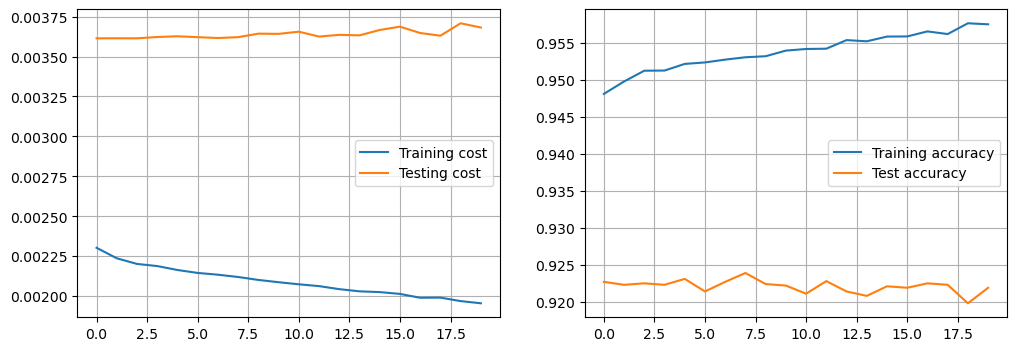

In [29]:
batch_size = 64

training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

learning_rate = 0.01
nepochs = 20

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0)

cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs, training_loader, test_loader)

plot_performance(cost_hist, cost_hist_test, acc_hist, acc_hist_test)

### Cross-Validation

Use 5-fold cross validation to estimate the accuracy and an error bar of the accuracy estimate.


In [31]:
from sklearn.model_selection import KFold
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

nepochs = 10

training_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())

# Define the KFold cross-validator
kfold = KFold(n_splits=5, shuffle=True)

# Initialize lists to store the outcomes of cross-validation
accuracies = []
losses = []

# KFold will give us indices to split data into train and test set
for fold, (train_ids, val_ids) in enumerate(kfold.split(training_data)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Define training and validation data loaders
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    train_loader = torch.utils.data.DataLoader(training_data, batch_size=64, sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(training_data, batch_size=64, sampler=val_subsampler)

    # Instantiate model and optimizer
    model = cnn_model()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    # Perform training and evaluation
    train_loss, val_loss, train_acc, val_acc = train_eval(model, optimizer, nepochs, train_loader, val_loader)

    # Store the results
    accuracies.extend(val_acc)
    losses.extend(val_loss)
    print(f'Validation accuracy for fold {fold}: {val_acc[-1]:.4f}')
    print('--------------------------------')

# Calculate the average and the standard deviation of the accuracies
average_accuracy = np.mean(accuracies)
std_deviation_accuracy = np.std(accuracies)

print(f'5-Fold Cross-Validation Accuracy: {average_accuracy:.4f} ± {std_deviation_accuracy:.4f}')

FOLD 0
--------------------------------
Epoch 0: Train Loss: 0.0158, Train Acc: 0.6699, Test Loss: 0.0105, Test Acc: 0.7472
Epoch 1: Train Loss: 0.0094, Train Acc: 0.7821, Test Loss: 0.0084, Test Acc: 0.8107
Epoch 2: Train Loss: 0.0082, Train Acc: 0.8106, Test Loss: 0.0078, Test Acc: 0.8222
Epoch 3: Train Loss: 0.0074, Train Acc: 0.8309, Test Loss: 0.0075, Test Acc: 0.8263
Epoch 4: Train Loss: 0.0069, Train Acc: 0.8442, Test Loss: 0.0069, Test Acc: 0.8448
Epoch 5: Train Loss: 0.0065, Train Acc: 0.8530, Test Loss: 0.0065, Test Acc: 0.8546
Epoch 6: Train Loss: 0.0063, Train Acc: 0.8588, Test Loss: 0.0063, Test Acc: 0.8622
Epoch 7: Train Loss: 0.0061, Train Acc: 0.8644, Test Loss: 0.0062, Test Acc: 0.8584
Epoch 8: Train Loss: 0.0059, Train Acc: 0.8681, Test Loss: 0.0060, Test Acc: 0.8670
Epoch 9: Train Loss: 0.0058, Train Acc: 0.8699, Test Loss: 0.0059, Test Acc: 0.8713
Validation accuracy for fold 0: 0.8713
--------------------------------
FOLD 1
--------------------------------
Epoch 0:

### Analyse Different Optimisers with different Settings 

Use the code above to explore different settings for the different optimizers. Use batchsize 64.

1. *SGD*: Refer to the results from above - for later comparison.
<br>

2. *Momentum*: Play with at least three different settings when using momentum: learning rate, momentum parameter, Nesterov flag. Start with momentum=0.9 without Nesterov and suitable learning rate, then vary the momentum parameter and independently the learning rate. Can you see an impact of using Nesterov? What is your recommended best choice (lr, momentum, nesterov, nepochs) for the given problem?
<br>

3. *RMSProp*: Same thing now for RMSprop (without momentum). Play with at least three different settings when using RMSprop: lr, alpha. Start with the default settings of pytorch with (lr=0.01, alpha=0.99,centered=False). Then vary alpha and independently the learning rate. Can you see an impact when using centered=True? What is your recommended best choice (learning rate, alpha, centered, nepochs) for the given problem?<br>
<br>

4. *Adam*: Same thing now for Adam. Play with at least three different settings. Start with the default settings of pytorch. What is your recommended best choice for the given problem?<br>
<br>


In [ ]:
nbatch = 64
nepochs = 

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)
    
model = mlp()
optimizer = ...
cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs, training_loader, validation_loader)


### Plots and Comments (for the different steps described above) 

### Learning Rate Schedule

Modify your `train_eval` method implemented above to support using a learning rate schedule for SGD (without momentum) - by using e.g. StepLR. What are your preferred settings for the given task?

Compare and evaluate the training performance with the results obtained for the different optimizers above and provide a judgement.